In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from xgboost import plot_importance, plot_tree
plt.style.use('fivethirtyeight')

In [2]:
fmt = lambda dates: datetime.strptime(dates, "%d/%m/%Y %H:%M")
train = pd.read_csv('./data/train.csv', index_col = [0], parse_dates = [1], date_parser = fmt)
test = pd.read_csv('./data/test.csv', index_col = [0], parse_dates = [1], date_parser = fmt)

In [3]:
train

,date,speed
id,,
0,2017-01-01 00:00:00,43.002930
1,2017-01-01 01:00:00,46.118696
2,2017-01-01 02:00:00,44.294158
3,2017-01-01 03:00:00,41.067468
4,2017-01-01 04:00:00,46.448653
...,...,...
14001,2018-12-31 12:00:00,19.865269
14002,2018-12-31 15:00:00,17.820375
14003,2018-12-31 16:00:00,12.501851


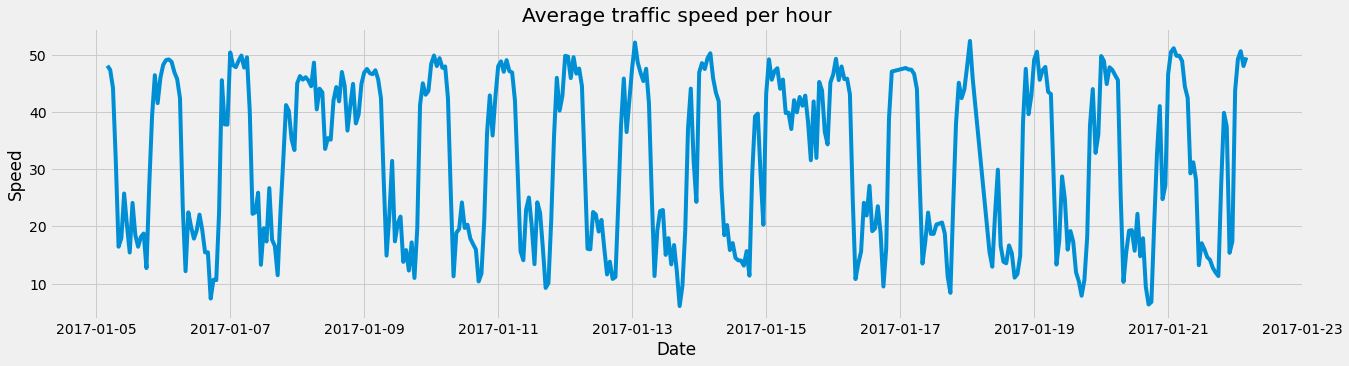

In [4]:
xx = train[100:500]["date"]
yy = train[100:500]["speed"]
plt.figure(figsize=(20, 5))
plt.plot(xx, yy)
plt.xlabel("Date")
plt.ylabel("Speed")
plt.title("Average traffic speed per hour")
plt.show()

In [5]:
def generate_feature(df):
    df["hfd"] = df["date"].dt.hour
    df["dfw"] = df["date"].dt.dayofweek
    df["dfm"] = df["date"].dt.day
    df["dfy"] = df["date"].dt.dayofyear
    df["wfy"] = np.int64(df["date"].dt.isocalendar().week)
    df["mfy"] = df["date"].dt.month
    df["qfy"] = df["date"].dt.quarter
    df["y"] = df["date"].dt.year
    
    x = df[["hfd", "dfw", "dfm", "dfy", "wfy", "mfy", "qfy", "y"]]
    return x

In [6]:
x_train = generate_feature(train)
y_train = train["speed"]
x_test = generate_feature(test)

In [7]:
help(xgb.XGBRegressor)

Help on class XGBRegressor in module xgboost.sklearn:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain', **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of trees to fit.
 |  verbosity : int
 |      The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |  silent : boolean
 |      Whether to print messages while running boostin

In [8]:
model = xgb.XGBRegressor(n_estimators = 1000)
model.fit(x_train, y_train, verbose = True)

[00:40:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [9]:
help(model.fit)

Help on method fit in module xgboost.sklearn:

fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None, sample_weight_eval_set=None, callbacks=None) method of xgboost.sklearn.XGBRegressor instance
    Fit the gradient boosting model
    
    Parameters
    ----------
    X : array_like
        Feature matrix
    y : array_like
        Labels
    sample_weight : array_like
        instance weights
    eval_set : list, optional
        A list of (X, y) tuple pairs to use as a validation set for
        early-stopping
    sample_weight_eval_set : list, optional
        A list of the form [L_1, L_2, ..., L_n], where each L_i is a list of
        instance weights on the i-th validation set.
    eval_metric : str, callable, optional
        If a str, should be a built-in evaluation metric to use. See
        doc/parameter.rst. If callable, a custom evaluation metric. The call
        signature is func(y_predicted, y_true) where 

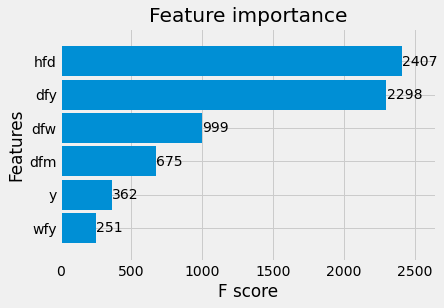

In [10]:
ipt = plot_importance(model, height = 0.9)

In [11]:
test["speed"] = model.predict(x_test)

In [12]:
test = test["speed"]

In [13]:
test.to_csv("./submission.csv", index = True, sep = ",")